<a href="https://colab.research.google.com/github/Anushka-Verma-CODES/Colab_Notebook/blob/main/AI_MST_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CPU Temperature Prediction - Synthetic Dataset

**Google Cloud AI - Server Temperature Forecasting**

This notebook trains ML models to predict CPU temperature at:
- **Now**: Current temperature estimation
- **+5 minutes**: Short-term forecast
- **+10 minutes**: Medium-term forecast

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
print('Libraries loaded!')

Libraries loaded!


## 1. Load Dataset

In [ ]:
local_file_path = 'synthetic_dataset.csv'

try:
    df = pd.read_csv(local_file_path)
    print(f"Successfully loaded '{local_file_path}' locally.")
    display(df.head())
except FileNotFoundError:
    print(f"Error: The file '{local_file_path}' was not found. Please ensure it is uploaded to your Colab session.")


print(f'Loaded {len(df):,} rows')
print(f'Servers: {df["server_id"].nunique()}')
print(f'Columns: {list(df.columns)}')
df.head()

Successfully loaded 'synthetic_dataset.csv' locally.


,timestamp,server_id,cpu_util_pct,mem_util_pct,clock_mhz,power_w,voltage_v,current_a,ambient_c,fan_rpm,cpu_temp_c,y_5m,y_10m,temp_lag_1m,temp_lag_5m
0,2024-01-01 00:01:00,server_000,0.000000,30.139513,1238.363612,166.598262,12.087765,13.782388,22.109610,2260.692224,40.605875,40.208500,41.355462,41.002866,NaN
1,2024-01-01 00:02:00,server_000,4.945001,27.848925,1304.827327,185.038048,12.041447,15.366761,21.833326,2344.125693,40.415596,40.321491,40.975488,40.605875,NaN
2,2024-01-01 00:03:00,server_000,5.425880,31.682777,1446.601381,192.666745,12.013200,16.037920,22.494543,2285.379956,40.289828,40.662895,41.131766,40.415596,NaN
3,2024-01-01 00:04:00,server_000,10.751794,25.121385,1618.074560,238.910218,11.888882,20.095263,22.099816,2125.273890,40.343629,40.921234,41.417258,40.289828,NaN
4,2024-01-01 00:05:00,server_000,5.729666,35.366883,1359.771778,190.935218,11.891075,16.057019,21.934963,2257.327675,40.374833,41.802669,41.259496,40.343629,41.002866


Loaded 105,487 rows
Servers: 3
Columns: ['timestamp', 'server_id', 'cpu_util_pct', 'mem_util_pct', 'clock_mhz', 'power_w', 'voltage_v', 'current_a', 'ambient_c', 'fan_rpm', 'cpu_temp_c', 'y_5m', 'y_10m', 'temp_lag_1m', 'temp_lag_5m']


,timestamp,server_id,cpu_util_pct,mem_util_pct,clock_mhz,power_w,voltage_v,current_a,ambient_c,fan_rpm,cpu_temp_c,y_5m,y_10m,temp_lag_1m,temp_lag_5m
0,2024-01-01 00:01:00,server_000,0.000000,30.139513,1238.363612,166.598262,12.087765,13.782388,22.109610,2260.692224,40.605875,40.208500,41.355462,41.002866,NaN
1,2024-01-01 00:02:00,server_000,4.945001,27.848925,1304.827327,185.038048,12.041447,15.366761,21.833326,2344.125693,40.415596,40.321491,40.975488,40.605875,NaN
2,2024-01-01 00:03:00,server_000,5.425880,31.682777,1446.601381,192.666745,12.013200,16.037920,22.494543,2285.379956,40.289828,40.662895,41.131766,40.415596,NaN
3,2024-01-01 00:04:00,server_000,10.751794,25.121385,1618.074560,238.910218,11.888882,20.095263,22.099816,2125.273890,40.343629,40.921234,41.417258,40.289828,NaN
4,2024-01-01 00:05:00,server_000,5.729666,35.366883,1359.771778,190.935218,11.891075,16.057019,21.934963,2257.327675,40.374833,41.802669,41.259496,40.343629,41.002866


In [ ]:
print('Null values:')
print(df.isnull().sum())

Null values:
timestamp        0
server_id        0
cpu_util_pct     0
mem_util_pct     0
clock_mhz        0
power_w          0
voltage_v        0
current_a        0
ambient_c        0
fan_rpm          0
cpu_temp_c       0
y_5m             0
y_10m            0
temp_lag_1m      1
temp_lag_5m     13
dtype: int64


In [ ]:
# Basic statistics
df.describe()

,cpu_util_pct,mem_util_pct,clock_mhz,power_w,voltage_v,current_a,ambient_c,fan_rpm,cpu_temp_c,y_5m,y_10m,temp_lag_1m,temp_lag_5m
count,105487.000000,105487.000000,105487.000000,105487.000000,105487.000000,105487.000000,105487.000000,105487.000000,105487.000000,105487.000000,105487.000000,105486.000000,105474.000000
mean,32.356193,42.914344,1891.662901,310.148936,11.999659,25.848534,22.240379,3915.424701,52.771323,52.772120,52.772028,52.771044,52.771499
std,26.460670,11.720632,469.432811,131.165865,0.099640,10.934702,2.563255,1687.720303,10.637344,10.637113,10.637358,10.637386,10.637479
min,0.000000,12.650456,1029.208630,88.899198,11.552722,7.435757,18.000000,1659.648122,35.050289,35.050289,35.050289,35.050289,35.050289
25%,11.524705,34.395600,1520.816691,212.209010,11.932312,17.692605,20.360942,2687.464977,44.747681,44.747681,44.747135,44.747610,44.747896
50%,24.412113,40.429802,1784.576082,272.418106,11.999311,22.697082,22.218766,3421.918374,50.809475,50.810215,50.810940,50.808959,50.809534
75%,47.663216,49.692544,2190.328422,367.105312,12.066785,30.611665,24.033607,4578.136504,58.485230,58.486023,58.486023,58.483874,58.483464
max,100.000000,90.000000,3212.132853,706.653224,12.427659,58.879502,27.837646,11028.585622,88.582666,88.582666,88.582666,88.582666,88.582666


## 2. Exploratory Data Analysis

In [ ]:
df_plot = df.sample(n=min(100000, len(df)), random_state=42)
print(f'Sampled {len(df_plot):,} rows for plotting')

Sampled 100,000 rows for plotting


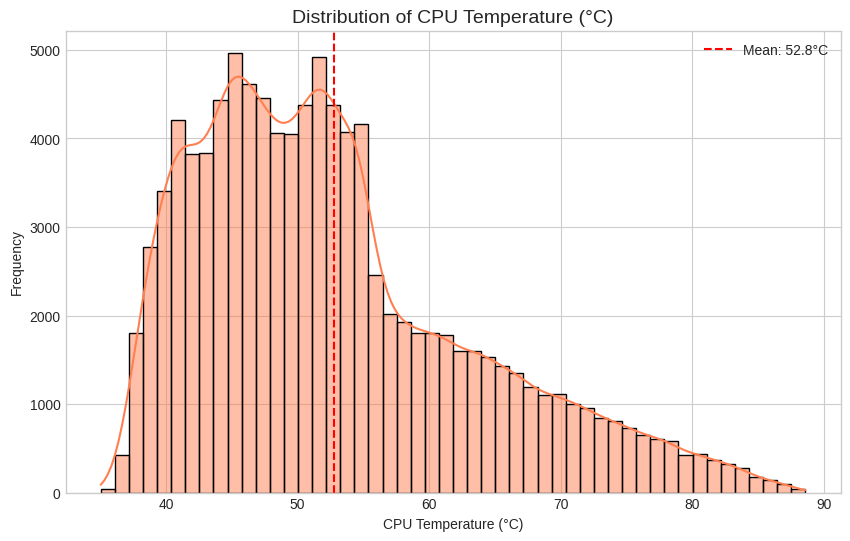

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_plot['cpu_temp_c'], kde=True, bins=50, color='coral')
plt.title('Distribution of CPU Temperature (°C)', fontsize=14)
plt.xlabel('CPU Temperature (°C)')
plt.ylabel('Frequency')
plt.axvline(df_plot['cpu_temp_c'].mean(), color='red', linestyle='--', label=f'Mean: {df_plot["cpu_temp_c"].mean():.1f}°C')
plt.legend()
plt.show()

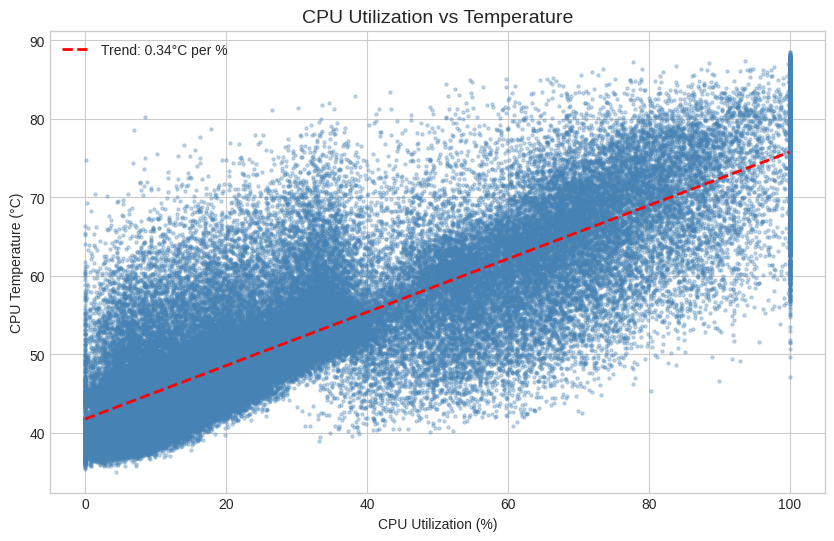

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_plot['cpu_util_pct'], df_plot['cpu_temp_c'], alpha=0.3, s=5, c='steelblue')
plt.title('CPU Utilization vs Temperature', fontsize=14)
plt.xlabel('CPU Utilization (%)')
plt.ylabel('CPU Temperature (°C)')

z = np.polyfit(df_plot['cpu_util_pct'], df_plot['cpu_temp_c'], 1)
p = np.poly1d(z)
x_line = np.linspace(0, 100, 100)
plt.plot(x_line, p(x_line), 'r--', linewidth=2, label=f'Trend: {z[0]:.2f}°C per %')
plt.legend()
plt.show()

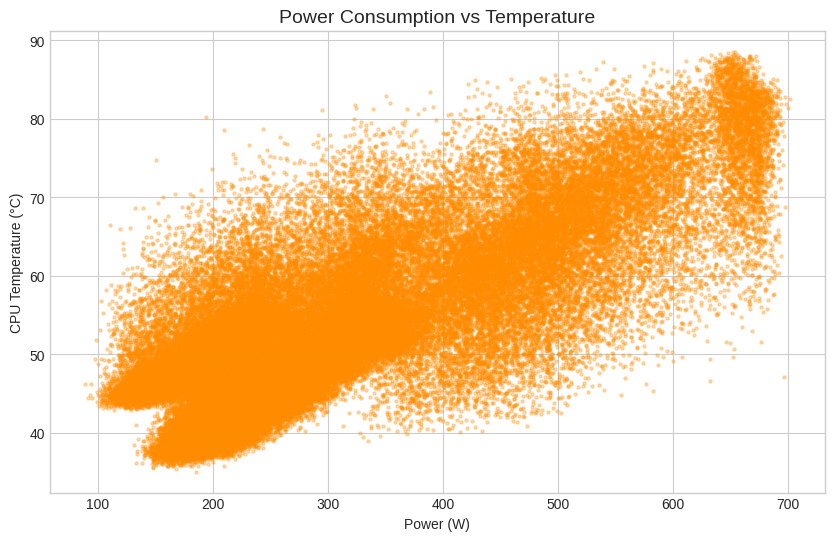

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_plot['power_w'], df_plot['cpu_temp_c'], alpha=0.3, s=5, c='darkorange')
plt.title('Power Consumption vs Temperature', fontsize=14)
plt.xlabel('Power (W)')
plt.ylabel('CPU Temperature (°C)')
plt.show()

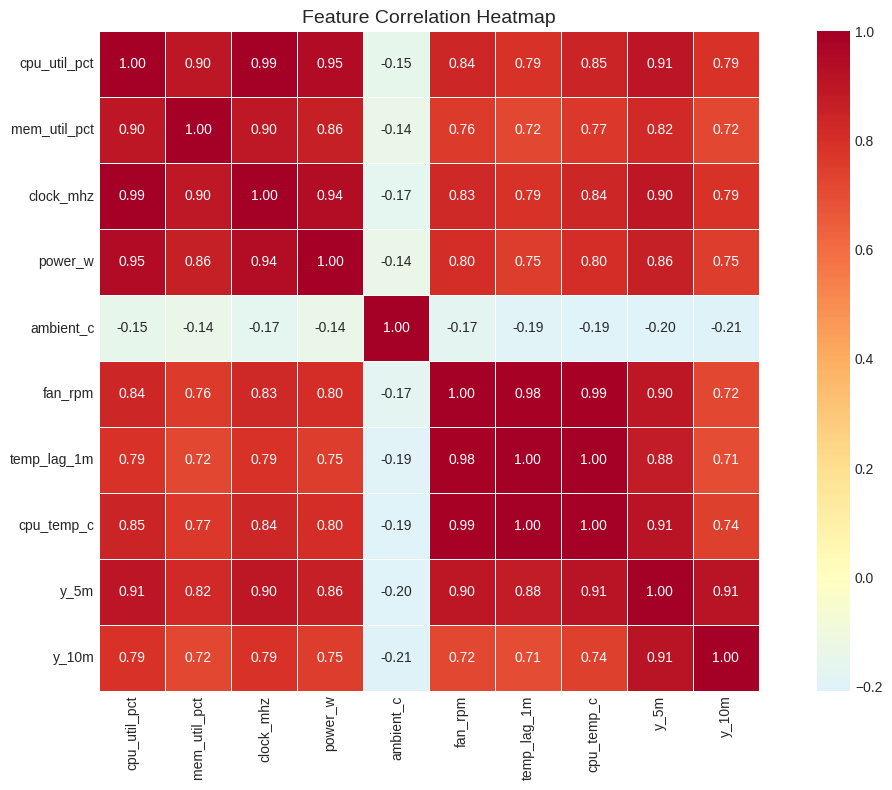

In [ ]:
plt.figure(figsize=(12, 8))
numeric_cols = ['cpu_util_pct', 'mem_util_pct', 'clock_mhz', 'power_w',
                'ambient_c', 'fan_rpm', 'temp_lag_1m', 'cpu_temp_c', 'y_5m', 'y_10m']
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=14)
plt.tight_layout()
plt.show()

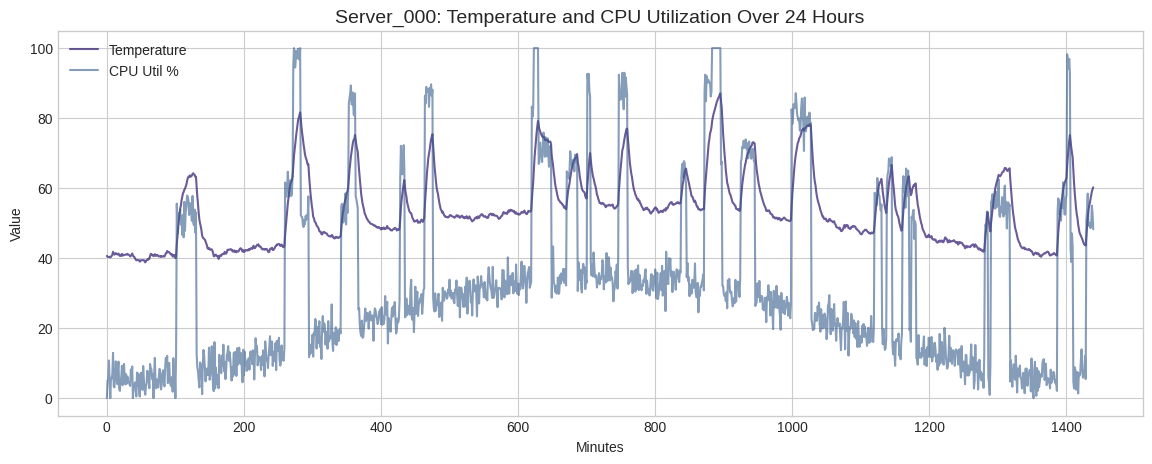

In [ ]:
server_sample = df[df['server_id'] == 'server_000'].head(1440)
plt.figure(figsize=(14, 5))
plt.plot(range(len(server_sample)), server_sample['cpu_temp_c'], label='Temperature', alpha=0.8)
plt.plot(range(len(server_sample)), server_sample['cpu_util_pct'], label='CPU Util %', alpha=0.6)
plt.title('Server_000: Temperature and CPU Utilization Over 24 Hours', fontsize=14)
plt.xlabel('Minutes')
plt.ylabel('Value')
plt.legend()
plt.show()

## 3. Verify Labels & Persistence Baseline

In [ ]:
print('Label Statistics:')
print(f"y_5m range: {df['y_5m'].min():.1f} - {df['y_5m'].max():.1f}°C")
print(f"y_10m range: {df['y_10m'].min():.1f} - {df['y_10m'].max():.1f}°C")

persist_5 = np.abs(df['y_5m'] - df['cpu_temp_c']).mean()
persist_10 = np.abs(df['y_10m'] - df['cpu_temp_c']).mean()

print(f'\nPersistence Baseline MAE:')
print(f'  +5m:  {persist_5:.3f}°C')
print(f'  +10m: {persist_10:.3f}°C')

Label Statistics:
y_5m range: 35.1 - 88.6°C
y_10m range: 35.1 - 88.6°C

Persistence Baseline MAE:
  +5m:  2.809°C
  +10m: 4.965°C


## 4. Feature Engineering

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', errors='coerce')
df = df.dropna(subset=['timestamp']) # Drop rows where timestamp conversion failed
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

df['temp_diff_1m'] = df['cpu_temp_c'] - df['temp_lag_1m']
df['temp_diff_5m'] = df['cpu_temp_c'] - df['temp_lag_5m']
df['cpu_util_diff'] = df.groupby('server_id')['cpu_util_pct'].diff().fillna(0)
df['power_diff'] = df.groupby('server_id')['power_w'].diff().fillna(0)

window_5 = df.groupby('server_id')['cpu_temp_c'].transform(
    lambda x: x.rolling(5, min_periods=1).mean())
df['temp_rolling_5m_mean'] = window_5

window_5_std = df.groupby('server_id')['cpu_temp_c'].transform(
    lambda x: x.rolling(5, min_periods=1).std().fillna(0))
df['temp_rolling_5m_std'] = window_5_std

df['cpu_rolling_5m_mean'] = df.groupby('server_id')['cpu_util_pct'].transform(
    lambda x: x.rolling(5, min_periods=1).mean())

df['temp_above_ambient'] = df['cpu_temp_c'] - df['ambient_c']
df['power_per_util'] = df['power_w'] / (df['cpu_util_pct'] + 1)
df['thermal_load'] = df['power_w'] / (df['fan_rpm'] + 100)

df['cpu_mem_interaction'] = df['cpu_util_pct'] * df['mem_util_pct'] / 100
df['cpu_ambient_interaction'] = df['cpu_util_pct'] * df['ambient_c'] / 100

df = df.dropna()

print('Feature Engineering Complete!')
print(f'Added features: temp_diff_1m, temp_diff_5m, cpu_util_diff, power_diff')
print(f'               temp_rolling_5m_mean, temp_rolling_5m_std, cpu_rolling_5m_mean')
print(f'               temp_above_ambient, power_per_util, thermal_load')
print(f'               cpu_mem_interaction, cpu_ambient_interaction')
print(f'\nTotal rows after cleaning: {len(df):,}')

Feature Engineering Complete!
Added features: temp_diff_1m, temp_diff_5m, cpu_util_diff, power_diff
               temp_rolling_5m_mean, temp_rolling_5m_std, cpu_rolling_5m_mean
               temp_above_ambient, power_per_util, thermal_load
               cpu_mem_interaction, cpu_ambient_interaction

Total rows after cleaning: 105,474


## 5. Prepare Train/Test Split

In [ ]:
df_model = df.sample(frac=0.2, random_state=42).reset_index(drop=True)
print(f'Using {len(df_model):,} rows for training')

Using 21,095 rows for training


In [ ]:
feature_cols = [

    'cpu_util_pct', 'mem_util_pct', 'clock_mhz', 'power_w',
    'voltage_v', 'current_a', 'ambient_c', 'fan_rpm',

    'temp_lag_1m', 'temp_lag_5m',

    'temp_diff_1m', 'temp_diff_5m', 'cpu_util_diff', 'power_diff',

    'temp_rolling_5m_mean', 'temp_rolling_5m_std', 'cpu_rolling_5m_mean',

    'temp_above_ambient', 'power_per_util', 'thermal_load',

    'cpu_mem_interaction', 'cpu_ambient_interaction',

    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos'
]

X = df_model[feature_cols]
y_now = df_model['cpu_temp_c']
y_5m = df_model['y_5m']
y_10m = df_model['y_10m']

print(f'Total features: {len(feature_cols)}')
print('\nFeature groups:')
print(f'  Base: 8, Lag: 2, Rate: 4, Rolling: 3, Physics: 3, Interaction: 2, Time: 4')

Total features: 26

Feature groups:
  Base: 8, Lag: 2, Rate: 4, Rolling: 3, Physics: 3, Interaction: 2, Time: 4


In [ ]:
X_train, X_test, y_now_train, y_now_test = train_test_split(
    X, y_now, test_size=0.2, random_state=42)
_, _, y_5m_train, y_5m_test = train_test_split(
    X, y_5m, test_size=0.2, random_state=42)
_, _, y_10m_train, y_10m_test = train_test_split(
    X, y_10m, test_size=0.2, random_state=42)

print(f'Train: {len(X_train):,}, Test: {len(X_test):,}')

Train: 16,876, Test: 4,219


## 6. Preprocessing

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Scaled features: {X_train_scaled.shape}')

Scaled features: (16876, 26)


**7. Model Training**


# **-Regression metrics**

In [ ]:
def regression_metrics(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # High temperature MAE (>80°C)
    mask = y_true > 80
    mae_high = mean_absolute_error(y_true[mask], y_pred[mask]) if mask.sum() > 0 else None

    return {
        "mae": float(mae),
        "rmse": float(rmse),
        "r2": float(r2),
        "mae_high_temp": None if mae_high is None else float(mae_high)
    }

# **-Persistent Baseline**

In [ ]:
persist_metrics = {
    "now": regression_metrics(y_now_test, y_now_test),
    "5m": regression_metrics(y_5m_test, y_now_test),
    "10m": regression_metrics(y_10m_test, y_now_test)
}

persist_metrics


{'now': {'mae': 0.0, 'rmse': 0.0, 'r2': 1.0, 'mae_high_temp': 0.0},
 '5m': {'mae': 2.8685878855204474,
  'rmse': 4.468637175476802,
  'r2': 0.8230441219351068,
  'mae_high_temp': 2.633559792677391},
 '10m': {'mae': 5.126403515216698,
  'rmse': 7.8008979956825835,
  'r2': 0.4567888691918355,
  'mae_high_temp': 7.9683313751411795}}

# **-Ridge Regression**

In [ ]:
from sklearn.linear_model import Ridge

ridge_params = {"alpha": 1.0}

ridge_now = Ridge(**ridge_params)
ridge_5m  = Ridge(**ridge_params)
ridge_10m = Ridge(**ridge_params)

ridge_now.fit(X_train_scaled, y_now_train)
ridge_5m.fit(X_train_scaled, y_5m_train)
ridge_10m.fit(X_train_scaled, y_10m_train)

ridge_now_pred = ridge_now.predict(X_test_scaled)
ridge_5m_pred  = ridge_5m.predict(X_test_scaled)
ridge_10m_pred = ridge_10m.predict(X_test_scaled)

ridge_metrics = {
    "now": regression_metrics(y_now_test, ridge_now_pred),
    "5m": regression_metrics(y_5m_test, ridge_5m_pred),
    "10m": regression_metrics(y_10m_test, ridge_10m_pred)
}

ridge_metrics


{'now': {'mae': 0.007913613574237569,
  'rmse': 0.010962533423537741,
  'r2': 0.9999989442212076,
  'mae_high_temp': 0.006671387960243774},
 '5m': {'mae': 1.9746933174953447,
  'rmse': 3.215271569774828,
  'r2': 0.9083884722015729,
  'mae_high_temp': 3.2189944610329535},
 '10m': {'mae': 4.304718789724544,
  'rmse': 6.10870108956663,
  'r2': 0.6668980218881199,
  'mae_high_temp': 8.73403009309462}}

# **-LightGBM**

In [ ]:
lgb_params = {
    "n_estimators": 300,
    "learning_rate": 0.05,
    "max_depth": -1,
    "random_state": 42
}

lgb_now = lgb.LGBMRegressor(**lgb_params)
lgb_5m  = lgb.LGBMRegressor(**lgb_params)
lgb_10m = lgb.LGBMRegressor(**lgb_params)

lgb_now.fit(X_train_scaled, y_now_train)
lgb_5m.fit(X_train_scaled, y_5m_train)
lgb_10m.fit(X_train_scaled, y_10m_train)

lgb_now_pred = lgb_now.predict(X_test_scaled)
lgb_5m_pred  = lgb_5m.predict(X_test_scaled)
lgb_10m_pred = lgb_10m.predict(X_test_scaled)

lgb_metrics = {
    "now": regression_metrics(y_now_test, lgb_now_pred),
    "5m": regression_metrics(y_5m_test, lgb_5m_pred),
    "10m": regression_metrics(y_10m_test, lgb_10m_pred)
}

lgb_metrics


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5665
[LightGBM] [Info] Number of data points in the train set: 16876, number of used features: 26
[LightGBM] [Info] Start training from score 52.889644
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5665
[LightGBM] [Info] Number of data points in the train set: 16876, number of used features: 26
[LightGBM] [Info] Start training from score 52.919773
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5665
[LightGBM] [Info] Number of data points in the train set: 16876, number of used features: 26
[LightGBM] [Info] Start t

{'now': {'mae': 0.1596207000402003,
  'rmse': 0.23729989397188359,
  'r2': 0.999505295157726,
  'mae_high_temp': 0.30536359381190686},
 '5m': {'mae': 1.9252117672796283,
  'rmse': 3.1738474073281258,
  'r2': 0.9107338322170629,
  'mae_high_temp': 2.9841250977588905},
 '10m': {'mae': 4.198045899366384,
  'rmse': 5.998138723435815,
  'r2': 0.6788466373006659,
  'mae_high_temp': 7.406958086177212}}

In [ ]:
rows = []
for horizon in ["now", "5m", "10m"]:
    rows.append({
        "Horizon": horizon,
        "Persistence MAE": persist_metrics[horizon]["mae"],
        "Persistence RMSE": persist_metrics[horizon]["rmse"],
        "Persistence R2": persist_metrics[horizon]["r2"],

        "Ridge MAE": ridge_metrics[horizon]["mae"],
        "Ridge RMSE": ridge_metrics[horizon]["rmse"],
        "Ridge R2": ridge_metrics[horizon]["r2"],

        "LightGBM MAE": lgb_metrics[horizon]["mae"],
        "LightGBM RMSE": lgb_metrics[horizon]["rmse"],
        "LightGBM R2": lgb_metrics[horizon]["r2"],
    })

df_results = pd.DataFrame(rows)
df_results


,Horizon,Persistence MAE,Persistence RMSE,Persistence R2,Ridge MAE,Ridge RMSE,Ridge R2,LightGBM MAE,LightGBM RMSE,LightGBM R2
0,now,0.000000,0.000000,1.000000,0.007914,0.010963,0.999999,0.159621,0.237300,0.999505
1,5m,2.868588,4.468637,0.823044,1.974693,3.215272,0.908388,1.925212,3.173847,0.910734
2,10m,5.126404,7.800898,0.456789,4.304719,6.108701,0.666898,4.198046,5.998139,0.678847


In [ ]:
def metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }

results = pd.DataFrame.from_dict({
    "Persistence": metrics(y_now_test, y_now_test), # Persistence uses y_now_test as its prediction
    "Ridge": metrics(y_now_test, ridge_now_pred),
    "LightGBM": metrics(y_now_test, lgb_now_pred)
}, orient="index")

results

,MAE,RMSE,R2
Persistence,0.000000,0.000000,1.000000
Ridge,0.006720,0.009452,0.999999
LightGBM,0.156998,0.235045,0.999492


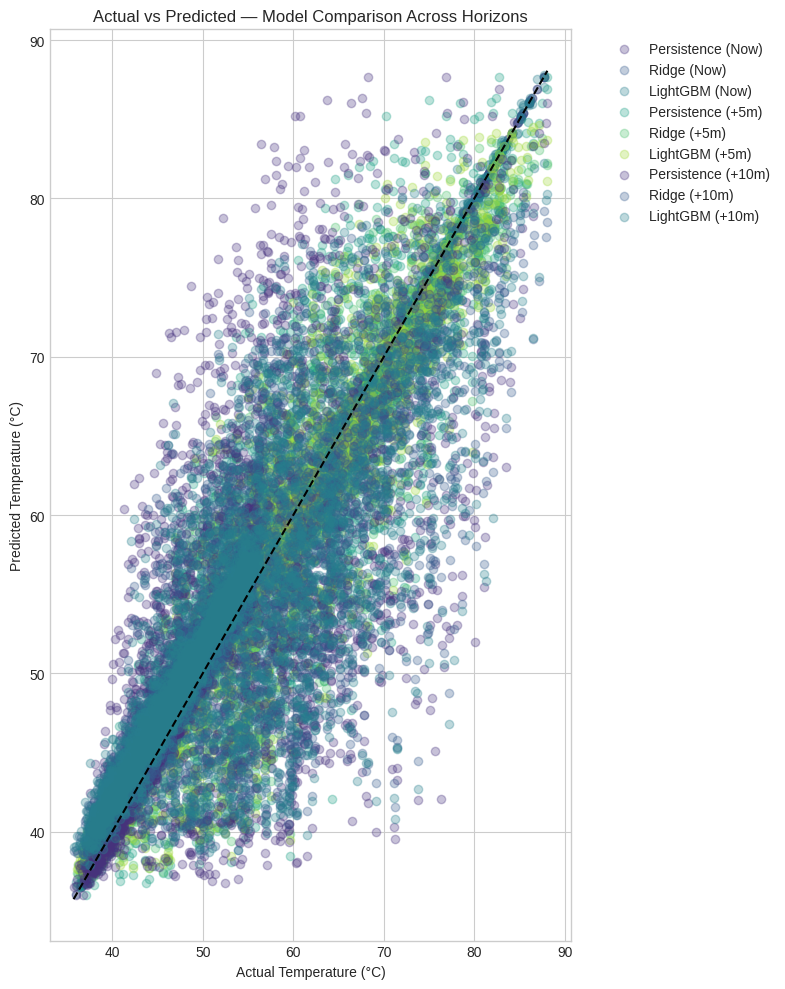

In [ ]:
plt.figure(figsize=(8,10))

plt.scatter(y_now_test, y_now_test, alpha=0.3, label="Persistence (Now)")
plt.scatter(y_now_test, ridge_now_pred, alpha=0.3, label="Ridge (Now)")
plt.scatter(y_now_test, lgb_now_pred, alpha=0.3, label="LightGBM (Now)")

# For 5-minute horizon
plt.scatter(y_5m_test, y_now_test, alpha=0.3, label="Persistence (+5m)")
plt.scatter(y_5m_test, ridge_5m_pred, alpha=0.3, label="Ridge (+5m)")
plt.scatter(y_5m_test, lgb_5m_pred, alpha=0.3, label="LightGBM (+5m)")

# For 10-minute horizon
plt.scatter(y_10m_test, y_now_test, alpha=0.3, label="Persistence (+10m)")
plt.scatter(y_10m_test, ridge_10m_pred, alpha=0.3, label="Ridge (+10m)")
plt.scatter(y_10m_test, lgb_10m_pred, alpha=0.3, label="LightGBM (+10m)")

plt.plot([min(y_now_test.min(), y_5m_test.min(), y_10m_test.min()), max(y_now_test.max(), y_5m_test.max(), y_10m_test.max())],
         [min(y_now_test.min(), y_5m_test.min(), y_10m_test.min()), max(y_now_test.max(), y_5m_test.max(), y_10m_test.max())], 'k--') # Add a black dashed line for perfect prediction

plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("Actual vs Predicted — Model Comparison Across Horizons")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

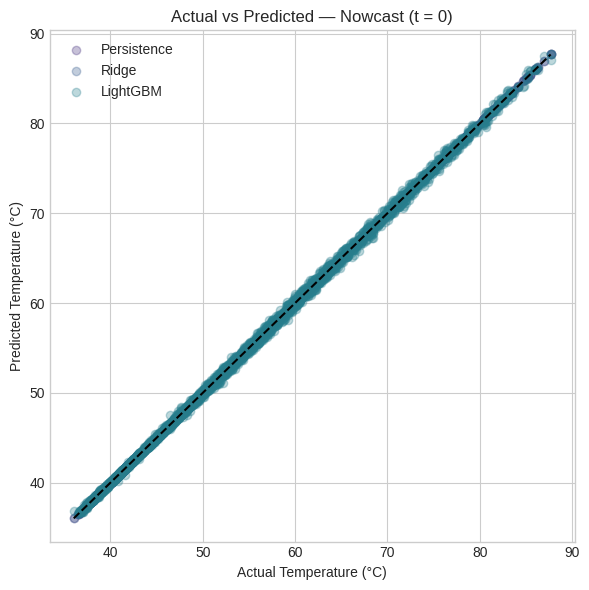

In [ ]:
plt.figure(figsize=(6,6))

plt.scatter(y_now_test, y_now_test, alpha=0.3, label="Persistence")
plt.scatter(y_now_test, ridge_now_pred, alpha=0.3, label="Ridge")
plt.scatter(y_now_test, lgb_now_pred, alpha=0.3, label="LightGBM")

min_val = y_now_test.min()
max_val = y_now_test.max()
plt.plot([min_val, max_val], [min_val, max_val], 'k--')

plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("Actual vs Predicted — Nowcast (t = 0)")
plt.legend()
plt.tight_layout()
plt.show()


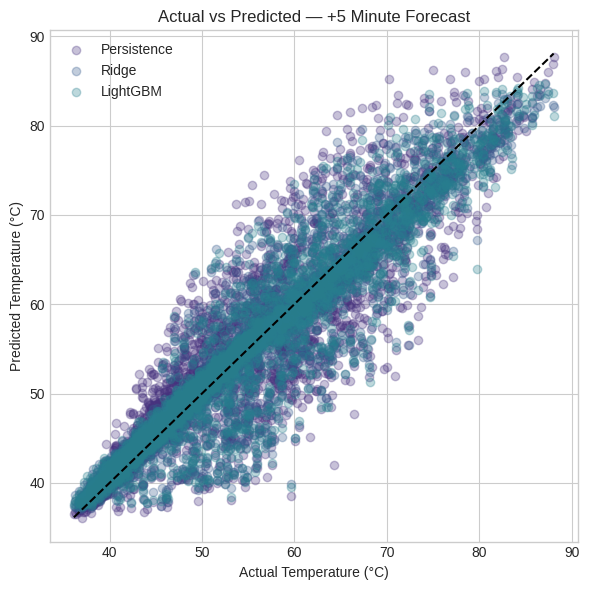

In [ ]:
plt.figure(figsize=(6,6))

plt.scatter(y_5m_test, y_now_test, alpha=0.3, label="Persistence")
plt.scatter(y_5m_test, ridge_5m_pred, alpha=0.3, label="Ridge")
plt.scatter(y_5m_test, lgb_5m_pred, alpha=0.3, label="LightGBM")

min_val = y_5m_test.min()
max_val = y_5m_test.max()
plt.plot([min_val, max_val], [min_val, max_val], 'k--')

plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("Actual vs Predicted — +5 Minute Forecast")
plt.legend()
plt.tight_layout()
plt.show()


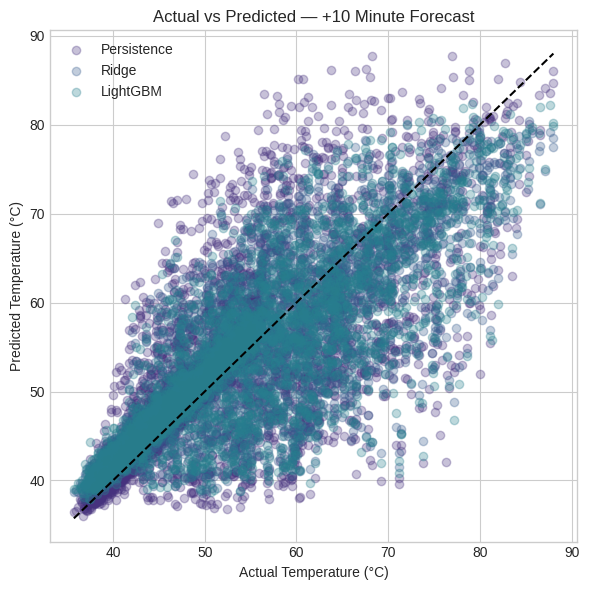

In [ ]:
plt.figure(figsize=(6,6))

plt.scatter(y_10m_test, y_now_test, alpha=0.3, label="Persistence")
plt.scatter(y_10m_test, ridge_10m_pred, alpha=0.3, label="Ridge")
plt.scatter(y_10m_test, lgb_10m_pred, alpha=0.3, label="LightGBM")

min_val = y_10m_test.min()
max_val = y_10m_test.max()
plt.plot([min_val, max_val], [min_val, max_val], 'k--')

plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("Actual vs Predicted — +10 Minute Forecast")
plt.legend()
plt.tight_layout()
plt.show()


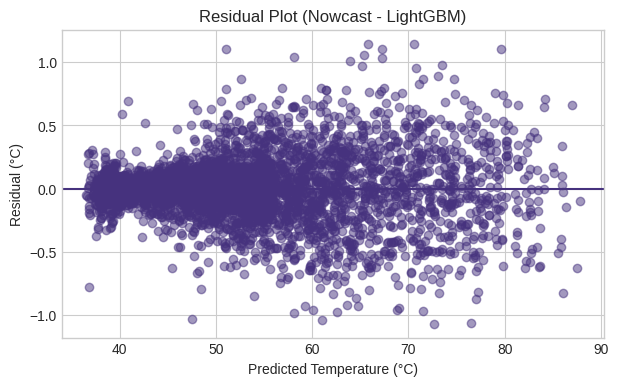

In [ ]:
residuals_now = y_now_test - lgb_now_pred

plt.figure(figsize=(7,4))
plt.scatter(lgb_now_pred, residuals_now, alpha=0.5)
plt.axhline(0)
plt.xlabel("Predicted Temperature (°C)")
plt.ylabel("Residual (°C)")
plt.title("Residual Plot (Nowcast - LightGBM)")
plt.show()

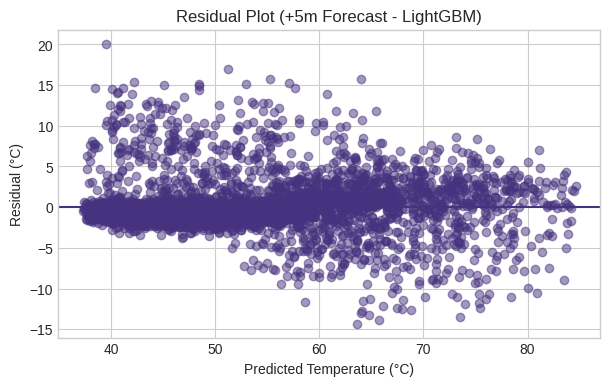

In [ ]:
residuals_5m = y_5m_test - lgb_5m_pred

plt.figure(figsize=(7,4))
plt.scatter(lgb_5m_pred, residuals_5m, alpha=0.5)
plt.axhline(0)
plt.xlabel("Predicted Temperature (°C)")
plt.ylabel("Residual (°C)")
plt.title("Residual Plot (+5m Forecast - LightGBM)")
plt.show()

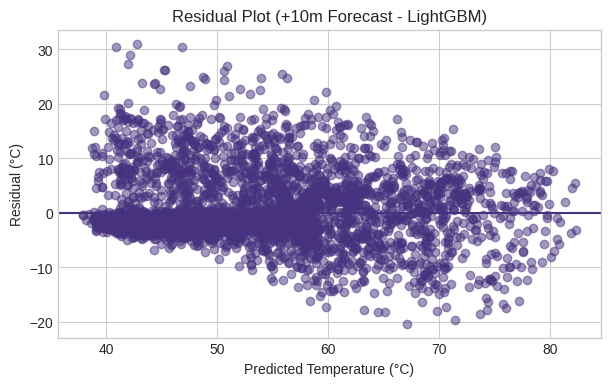

In [ ]:
residuals_10m = y_10m_test - lgb_10m_pred

plt.figure(figsize=(7,4))
plt.scatter(lgb_10m_pred, residuals_10m, alpha=0.5)
plt.axhline(0)
plt.xlabel("Predicted Temperature (°C)")
plt.ylabel("Residual (°C)")
plt.title("Residual Plot (+10m Forecast - LightGBM)")
plt.show()

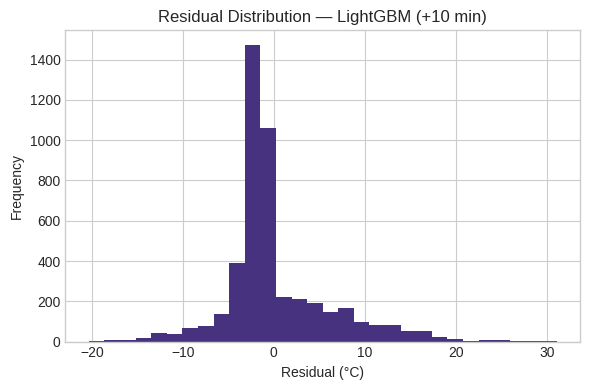

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(residuals_10m, bins=30)
plt.xlabel("Residual (°C)")
plt.ylabel("Frequency")
plt.title("Residual Distribution — LightGBM (+10 min)")
plt.tight_layout()
plt.show()

In [ ]:
print("Bias (Now):", residuals_now.mean())
print("Bias (+5m):", residuals_5m.mean())
print("Bias (+10m):", residuals_10m.mean())


Bias (Now): -0.001807837939701395
Bias (+5m): 0.027010495912757195
Bias (+10m): 0.13796283021518177


In [ ]:
def threshold_acc(y_true, y_pred, t):
    return (np.abs(y_true - y_pred) <= t).mean() * 100

for name, y_t, y_p in [
    ("Now",  y_now_test, lgb_now_pred),
    ("+5m",  y_5m_test,  lgb_5m_pred),
    ("+10m", y_10m_test, lgb_10m_pred),
]:
    print(name)
    for t in [1, 2, 5]:
        print(f"  Within ±{t}°C: {threshold_acc(y_t, y_p, t):.2f}%")


Now
  Within ±1°C: 99.72%
  Within ±2°C: 100.00%
  Within ±5°C: 100.00%
+5m
  Within ±1°C: 50.34%
  Within ±2°C: 74.75%
  Within ±5°C: 90.31%
+10m
  Within ±1°C: 14.45%
  Within ±2°C: 39.20%
  Within ±5°C: 75.07%


In [ ]:
def worst_case(y_true, y_pred):
    abs_err = np.abs(y_true - y_pred)
    return abs_err.max(), abs_err.mean()

for name, y_t, y_p in [
    ("Now",  y_now_test, lgb_now_pred),
    ("+5m",  y_5m_test,  lgb_5m_pred),
    ("+10m", y_10m_test, lgb_10m_pred),
]:
    max_err, mean_err = worst_case(y_t, y_p)
    print(name, "Max Error:", max_err, "| Mean Error:", mean_err)


Now Max Error: 1.1461374798280133 | Mean Error: 0.1569975149177337
+5m Max Error: 20.087609283804326 | Mean Error: 1.8708596408307971
+10m Max Error: 31.08555802080504 | Mean Error: 4.061267850252258


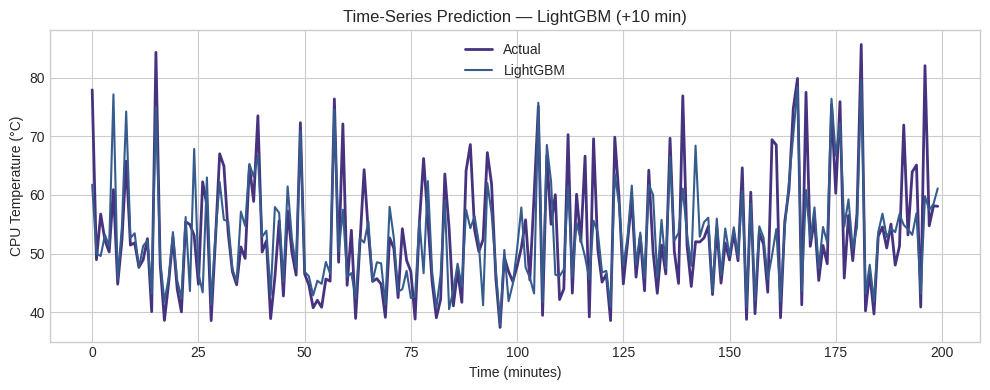

In [ ]:
n = 200

plt.figure(figsize=(10,4))
plt.plot(y_10m_test.values[:n], label="Actual", linewidth=2)
plt.plot(lgb_10m_pred[:n], label="LightGBM")
plt.xlabel("Time (minutes)")
plt.ylabel("CPU Temperature (°C)")
plt.title("Time-Series Prediction — LightGBM (+10 min)")
plt.legend()
plt.tight_layout()
plt.show()


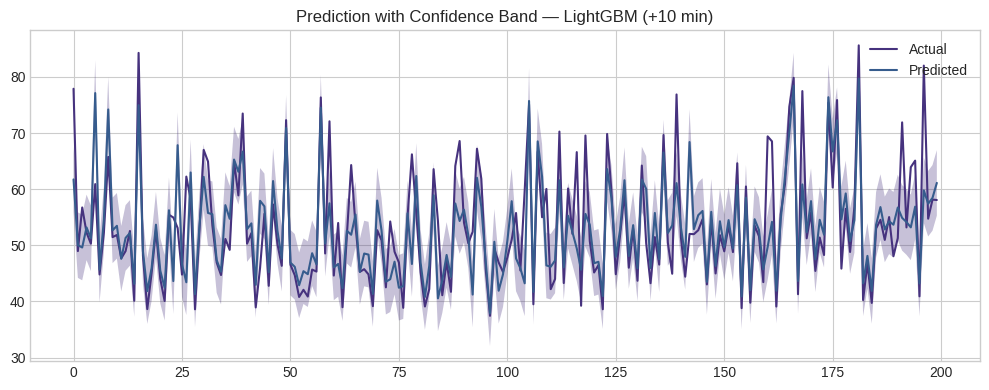

In [ ]:
rmse_10m = np.sqrt(mean_squared_error(y_10m_test, lgb_10m_pred))

plt.figure(figsize=(10,4))
plt.plot(y_10m_test.values[:n], label="Actual")
plt.plot(lgb_10m_pred[:n], label="Predicted")
plt.fill_between(
    range(n),
    lgb_10m_pred[:n] - rmse_10m,
    lgb_10m_pred[:n] + rmse_10m,
    alpha=0.3
)
plt.title("Prediction with Confidence Band — LightGBM (+10 min)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
summary = pd.DataFrame({
    "Horizon": ["Now", "+5 min", "+10 min"],
    "MAE": [
        mean_absolute_error(y_now_test,  lgb_now_pred),
        mean_absolute_error(y_5m_test,   lgb_5m_pred),
        mean_absolute_error(y_10m_test,  lgb_10m_pred),
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_now_test,  lgb_now_pred)),
        np.sqrt(mean_squared_error(y_5m_test,   lgb_5m_pred)),
        np.sqrt(mean_squared_error(y_10m_test,  lgb_10m_pred)),
    ],
    "R2": [
        r2_score(y_now_test,  lgb_now_pred),
        r2_score(y_5m_test,   lgb_5m_pred),
        r2_score(y_10m_test,  lgb_10m_pred),
    ]
})

summary


,Horizon,MAE,RMSE,R2
0,Now,0.156998,0.235045,0.999492
1,+5 min,1.870860,3.100319,0.911169
2,+10 min,4.061268,5.841090,0.682443
